<a href="https://colab.research.google.com/github/daleas0120/Example_notebooks/blob/main/LSTM_AE_Anomaly_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Grid Fault Prediction
Ashley S. Dale

Power grid fault detection can be framed as an anomaly detection problem, and approached using machine learning techniques. In this notebook, voltage and current time series data from a three-phase power system is analyzed using a Long Short Term Memory Autoencoder (LSTM-AE). The LSTM-AE learns to take an input sequence and reconstruct; the reconstruction error is minimized during this process. When the LSTM-AE is required to reconstruct data outside the training data distribution, reconstruction error increases and signals that the data can be considered anomalous. Here, the LSTM-AE is trained using data from the power grid in a correct state, and the reconstruction scores of the network in various anomalous states are examined. The results are not promising. Anomalous scores are not strongly correlated with the onset of a power grid fault. This is attributed to the simplicity of the LSTM-AE architecture and lack of data. A brief discussion on what can be done to improve results is presented.

In [ ]:
import numpy as np
import sklearn as skl
import pandas as pd
import csv
import matplotlib.pyplot as plt
import keras
from keras import layers

from tqdm import tqdm, trange
import tensorflow as tf
from scipy.signal import find_peaks

2023-10-27 23:26:58.149504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data

[The data may be downloaded directly from here](https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification) and placed in the correct location.

>We have modeled a power system in MATLAB to simulate fault analysis. The power system consists of 4 generators of 11 × 10^3 V, each pair located at each end of the transmission line. Transformers are present in between to simulate and study the various faults at the midpoint of the transmission line.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train_file = "/content/drive/MyDrive/data/classData.csv"
train = pd.read_csv(train_file)
test_file = "/content/drive/MyDrive/data/detect_dataset.csv"
test = pd.read_csv(test_file)

## Train Data
Inspecting the train data to understand the available features:

In [ ]:
train

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983
...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690


Plotting the current data...

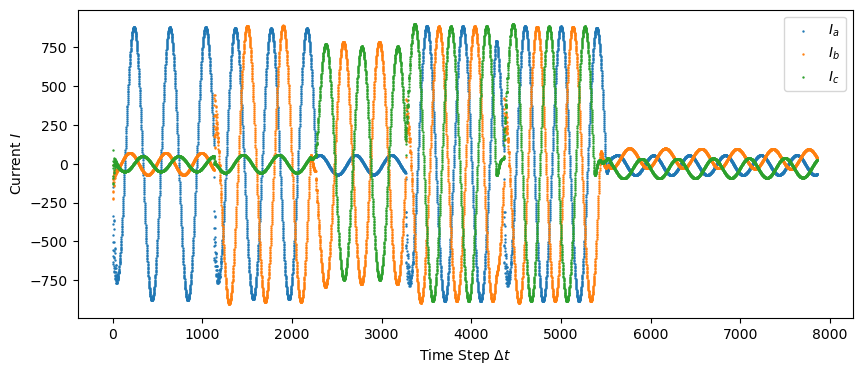

In [ ]:
plt.figure(figsize = (10,4))
plt.scatter(np.linspace(0, len(train["Ia"]), len(train["Ia"])), train["Ia"], s=0.5, label="$I_a$")
plt.scatter(np.linspace(0, len(train["Ia"]), len(train["Ib"])), train["Ib"], s=0.5, label="$I_b$")
plt.scatter(np.linspace(0, len(train["Ia"]), len(train["Ic"])), train["Ic"], s=0.5, label="$I_c$")
plt.legend()
plt.xlabel('Time Step $\Delta t$')
plt.ylabel('Current $I$')
plt.savefig("figures/train_data_current.png")
plt.show()

and the voltage data ...

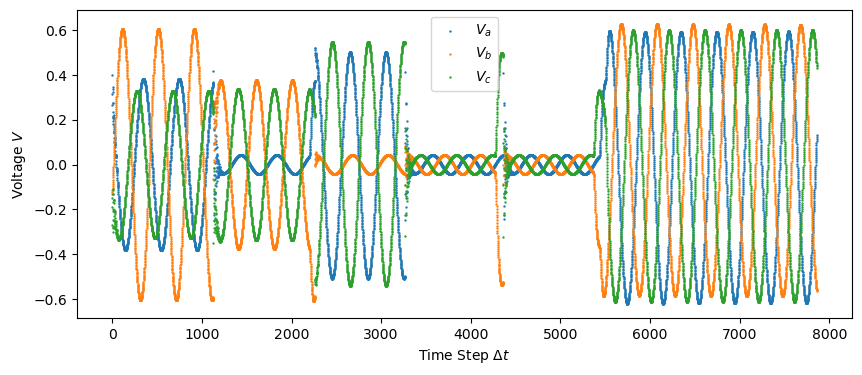

In [ ]:
plt.figure(figsize = (10,4))
plt.scatter(np.linspace(0, len(train["Va"]), len(train["Va"])), train["Va"], s=0.5, label="$V_a$")
plt.scatter(np.linspace(0, len(train["Vb"]), len(train["Vb"])), train["Vb"], s=0.5, label="$V_b$")
plt.scatter(np.linspace(0, len(train["Vc"]), len(train["Vc"])), train["Vc"], s=0.5, label="$V_c$")
plt.xlabel('Time Step $\Delta t$')
plt.ylabel('Voltage $V$')
plt.savefig("figures/train_data_voltage.png")
plt.legend()
plt.show()

### Convert one-hot labels to integers
One-hot|Description|Integer
---|---|---
[0 0 0 0] | No Fault | 0
[1 0 0 1] | LG fault (Between Phase A and Ground) | 9
[0 0 1 1] | LL fault (Between Phase A and Phase B) | 3
[1 0 1 1] | LLG Fault (Between Phases A,B and Ground) | 11
[0 1 1 1] | LLL Fault (Between all three phases) | 7
[1 1 1 1] | LLLG fault (Three phase symmetrical fault) | 15


In [ ]:
train_arr = np.array(train)
num_rows = train_arr.shape[0]

In [ ]:
new_labels = []
for idx in trange(num_rows):
    data_pt = train_arr[idx, :]
    label = str(int(data_pt[0]))+str(int(data_pt[1]))+str(int(data_pt[2]))+str(int(data_pt[3]))
    x = int(label, 2)
    new_labels.append(x)

100%|█████████████████████████████████████████████████████████████████████████████████████| 7861/7861 [00:00<00:00, 393500.70it/s]


In [ ]:
training_data_idx = np.where(np.array(new_labels) == 0)

In [ ]:
train_data = train_arr[np.array(new_labels) == 0][:, 4:]
y_labels = np.zeros(len(train_data))

In [ ]:
not_train_data = train_arr[np.array(new_labels) != 0][:, 4:]

In [ ]:
train['label'] = new_labels

## No-Fault Data

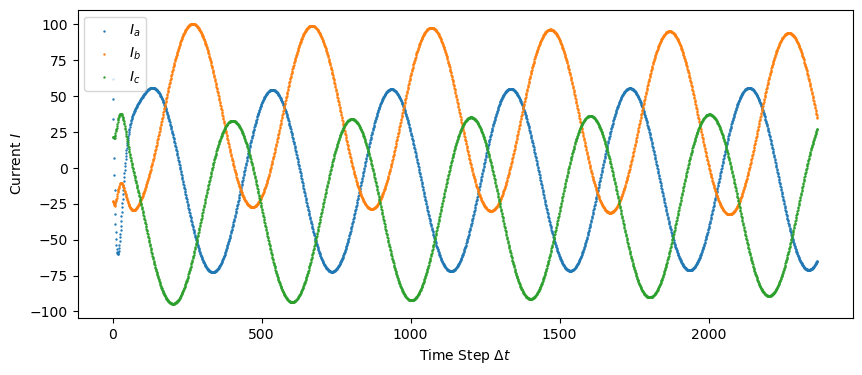

In [ ]:
plt.figure(figsize = (10,4))
plt.scatter(np.linspace(0, len(train_data), len(train_data)), train_data[:, 0], s=0.5, label="$I_a$")
plt.scatter(np.linspace(0, len(train_data), len(train_data)), train_data[:, 1], s=0.5, label="$I_b$")
plt.scatter(np.linspace(0, len(train_data), len(train_data)), train_data[:, 2], s=0.5, label="$I_c$")
plt.legend()
plt.xlabel('Time Step $\Delta t$')
plt.ylabel('Current $I$')
plt.savefig("figures/train_data_current.png")
plt.show()

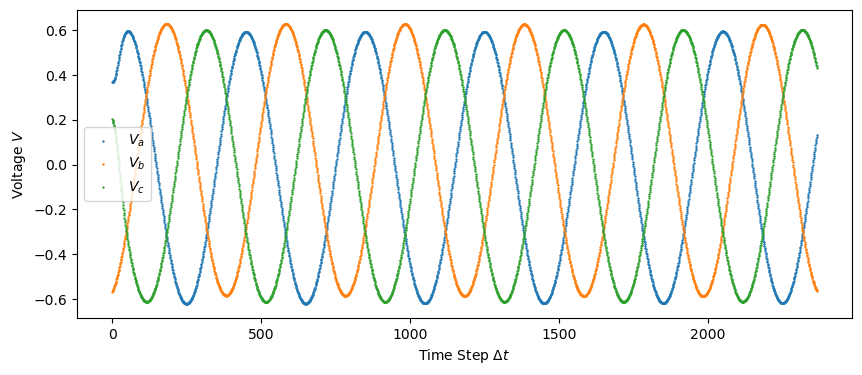

In [ ]:
plt.figure(figsize = (10,4))
plt.scatter(np.linspace(0, len(train_data), len(train_data)), train_data[:, 3], s=0.5, label="$V_a$")
plt.scatter(np.linspace(0, len(train_data), len(train_data)), train_data[:, 4], s=0.5, label="$V_b$")
plt.scatter(np.linspace(0, len(train_data), len(train_data)), train_data[:, 5], s=0.5, label="$V_c$")
plt.legend()
plt.xlabel('Time Step $\Delta t$')
plt.ylabel('Voltage $V$')
plt.savefig("figures/train_data_voltage.png")
plt.legend()
plt.show()

Format the data to be suitable for an LSTM-AE:

In [ ]:
def make_seq(data_arr, window):
    data = []
    for idx in trange(len(data_arr) - window):
        data.append(data_arr[idx:idx+window, :])

    print(np.array(data).shape)
    return np.array(data)

In [ ]:
timesteps = 55
crop_pts = np.mod(len(train_data), timesteps)

train_arr_noFault = make_seq(train_data, timesteps)

100%|████████████████████████████████████████████████████████████████████████████████████| 2310/2310 [00:00<00:00, 1426088.05it/s]

(2310, 55, 6)


## Test Data

Inspecting and visualizing the test data...

In [ ]:
test

,Output (S),Ia,Ib,Ic,Va,Vb,Vc,Unnamed: 7,Unnamed: 8
0,0,-170.472196,9.219613,161.252583,0.054490,-0.659921,0.605431,NaN,NaN
1,0,-122.235754,6.168667,116.067087,0.102000,-0.628612,0.526202,NaN,NaN
2,0,-90.161474,3.813632,86.347841,0.141026,-0.605277,0.464251,NaN,NaN
3,0,-79.904916,2.398803,77.506112,0.156272,-0.602235,0.445963,NaN,NaN
4,0,-63.885255,0.590667,63.294587,0.180451,-0.591501,0.411050,NaN,NaN
...,...,...,...,...,...,...,...,...,...
11996,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598,NaN,NaN
11997,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407,NaN,NaN
11998,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104,NaN,NaN
11999,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690,NaN,NaN


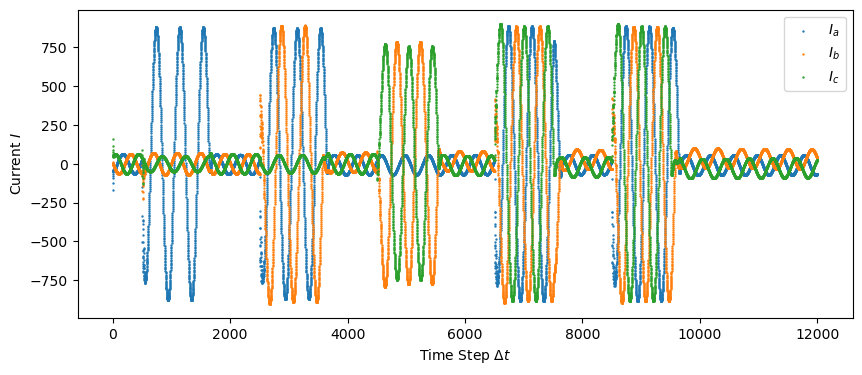

In [ ]:
plt.figure(figsize = (10,4))
plt.scatter(np.linspace(0, len(test["Ia"]), len(test["Ia"])), test["Ia"], s=0.5, label="$I_a$")
plt.scatter(np.linspace(0, len(test["Ia"]), len(test["Ib"])), test["Ib"], s=0.5, label="$I_b$")
plt.scatter(np.linspace(0, len(test["Ia"]), len(test["Ic"])), test["Ic"], s=0.5, label="$I_c$")
plt.legend()
plt.xlabel('Time Step $\Delta t$')
plt.ylabel('Current $I$')
plt.savefig("figures/test_data_current.png")
plt.show()

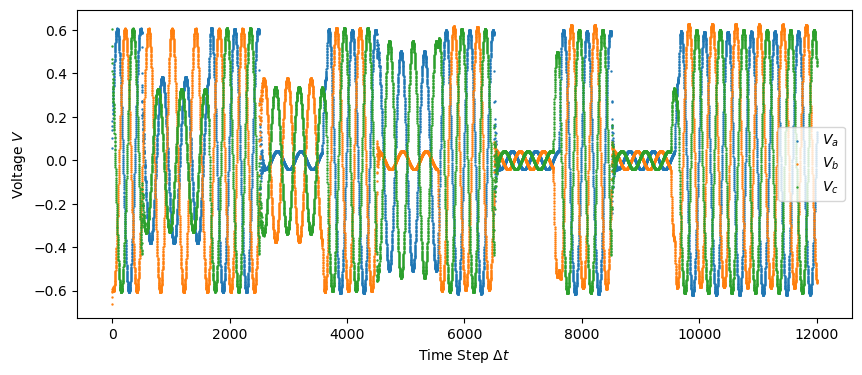

In [ ]:
plt.figure(figsize = (10,4))
plt.scatter(np.linspace(0, len(test["Va"]), len(test["Va"])), test["Va"], s=0.5, label="$V_a$")
plt.scatter(np.linspace(0, len(test["Vb"]), len(test["Vb"])), test["Vb"], s=0.5, label="$V_b$")
plt.scatter(np.linspace(0, len(test["Vc"]), len(test["Vc"])), test["Vc"], s=0.5, label="$V_c$")
plt.legend()
plt.xlabel('Time Step $\Delta t$')
plt.ylabel('Voltage $V$')
plt.savefig("figures/test_data_voltage.png")
plt.show()

In [ ]:
test_arr = np.array(test)[:, 1:7]
test_data = make_seq(test_arr, timesteps)

100%|██████████████████████████████████████████████████████████████████████████████████| 11946/11946 [00:00<00:00, 1486932.24it/s]

(11946, 55, 6)


In [ ]:
train_full = np.array(train_arr)[:, 4:]
train_full_data = make_seq(train_full, timesteps)

100%|████████████████████████████████████████████████████████████████████████████████████| 7806/7806 [00:00<00:00, 1549050.77it/s]

(7806, 55, 6)


# LSTM AE

### Network Definition

In [ ]:
input_dim = 6
latent_dim = 4
epochs = 5000

inputs = keras.Input(shape=(timesteps, input_dim))
encoded = layers.LSTM(latent_dim,  activation="tanh")(inputs)

decoded = layers.RepeatVector(timesteps)(encoded)
decoded = layers.LSTM(input_dim, return_sequences=True)(decoded)
loss_fn = tf.keras.losses.MeanAbsolutePercentageError()

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.00001)

In [ ]:
model2 = keras.Model(inputs, decoded)
model2.compile(keras.optimizers.Adam(learning_rate=3e-5), loss_fn)
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 55, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 4)                 176       
                                                                 
 repeat_vector (RepeatVecto  (None, 55, 4)             0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 55, 6)             264       
                                                                 
Total params: 440 (1.72 KB)
Trainable params: 440 (1.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training the model

In [ ]:
history2 = model2.fit(train_arr_noFault, train_arr_noFault,
                epochs=epochs,
                batch_size=32,
                shuffle=True,
                validation_data=(train_arr_noFault, train_arr_noFault),
                      callbacks=[callback])

Epoch 1/5000
73/73 [==============================] - 5s 31ms/step - loss: 142.6676 - val_loss: 141.7920
Epoch 2/5000
73/73 [==============================] - 2s 25ms/step - loss: 141.0114 - val_loss: 140.1616
Epoch 3/5000
73/73 [==============================] - 2s 25ms/step - loss: 139.3985 - val_loss: 138.5698
Epoch 4/5000
73/73 [==============================] - 2s 25ms/step - loss: 137.7897 - val_loss: 136.9484
Epoch 5/5000
73/73 [==============================] - 2s 23ms/step - loss: 136.1723 - val_loss: 135.3028
Epoch 6/5000
73/73 [==============================] - 2s 23ms/step - loss: 134.5354 - val_loss: 133.6566
Epoch 7/5000
73/73 [==============================] - 2s 25ms/step - loss: 132.9394 - val_loss: 132.0715
Epoch 8/5000
73/73 [==============================] - 2s 25ms/step - loss: 131.3307 - val_loss: 130.4837
Epoch 9/5000
73/73 [==============================] - 2s 24ms/step - loss: 129.6701 - val_loss: 128.8017
Epoch 10/5000
73/73 [==============================] - 

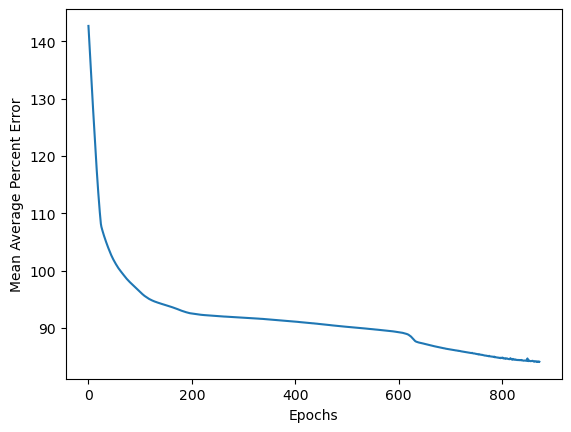

In [ ]:
plt.plot(np.linspace(0, len(history2.history['loss']), len(history2.history['loss']), epochs), history2.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Mean Average Percent Error")
plt.savefig('figures/LSTM_loss.png')
plt.show()

## Predictions

In [ ]:
results = model2.predict(
    test_data,
    batch_size=32,
    verbose="auto",
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)


374/374 [==============================] - 4s 9ms/step


In [ ]:
results2 = model2.predict(
    train_full_data,
    batch_size=32
)

244/244 [==============================] - 2s 10ms/step


## Calculate Statistics

In [ ]:
err = []
for gt, recon in zip(test_data, results):
    err.append((np.sum([gt[0, :] - recon[0, :]]/gt[0, :])/6)*100)

err2 = []
for gt, recon in zip(train_full_data, results2):
    err2.append((np.sum([gt[0, :] - recon[0, :]]/gt[0, :])/6)*100)

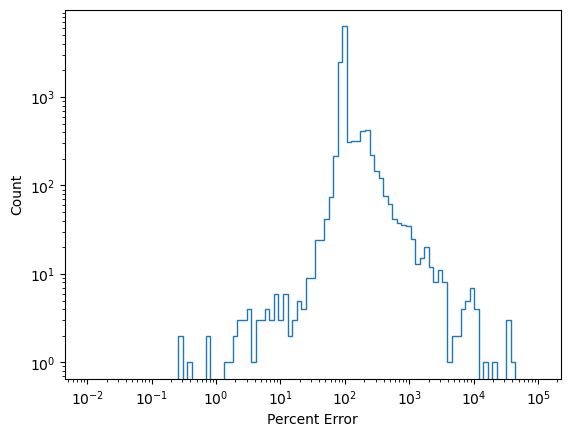

In [ ]:
counts, bins = np.histogram(np.abs(err), bins=np.logspace(-2, 5, 100))
fig, ax = plt.subplots(1, 1)
ax.stairs(counts, bins)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Percent Error')
ax.set_ylabel('Count')
plt.show()

# Finding Anomalies
The error data can be treated as a time series, where the anomalies correlate with high error values.  These values and the times can be identified using the `find_peaks` function.

In [ ]:
peaks, heights = find_peaks(np.abs(err), height=1500)

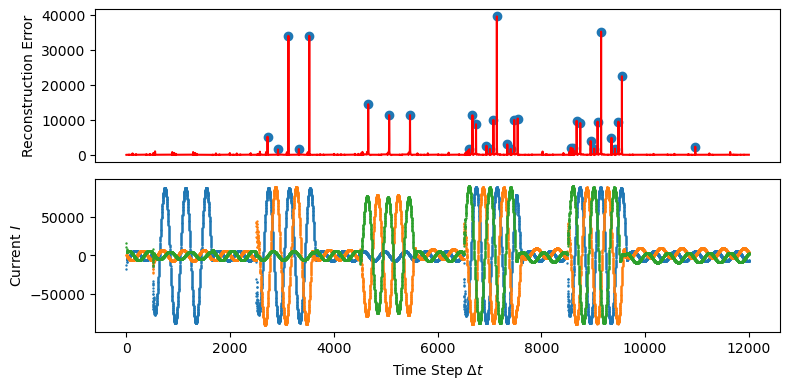

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].scatter(peaks, heights['peak_heights'])
ax[0].plot(np.linspace(0, len(err), len(err)), np.abs(err), c='r')
ax[0].set_xticks([])
ax[0].set_ylabel('Reconstruction Error')
ax[1].set_ylabel('')
ax[1].scatter(np.linspace(0, len(test["Ia"]), len(test["Ia"])), test["Ia"]*100, s=0.5, label="$I_a$")
ax[1].scatter(np.linspace(0, len(test["Ib"]), len(test["Ib"])), test["Ib"]*100, s=0.5, label="$I_b$")
ax[1].scatter(np.linspace(0, len(test["Ic"]), len(test["Ic"])), test["Ic"]*100, s=0.5, label="$I_c$")
ax[1].set_xlabel('Time Step $\Delta t$')
ax[1].set_ylabel('Current $I$')
plt.tight_layout()
plt.show()

Ideally, the large red error peaks should be at the leading edge of each domain shift.  This is not observed in the plot above.  The blue dots on the Reconstruction Error plot shows which points have been identified as peaks.

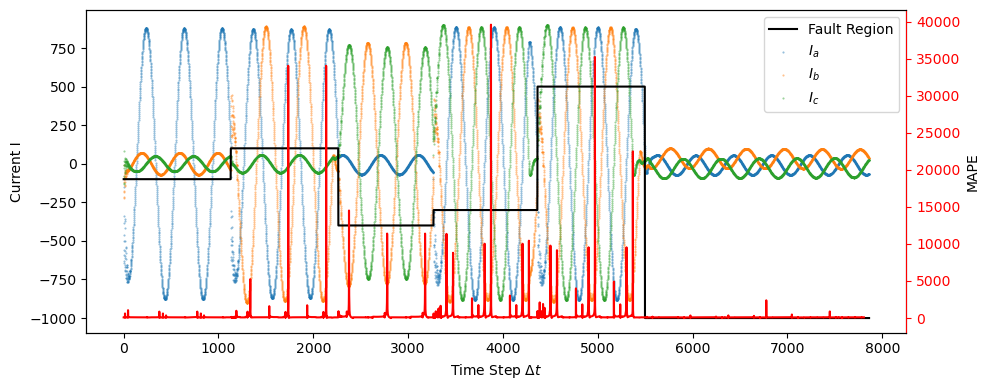

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(np.linspace(0, len(new_labels), len(new_labels)), np.array(new_labels)*100-1000, 'k', label='Fault Region')

ax.scatter(np.linspace(0, len(train["Ia"]), len(train["Ia"])), train["Ia"], s=0.25, label="$I_a$", alpha=0.5)
ax.scatter(np.linspace(0, len(train["Ib"]), len(train["Ib"])), train["Ib"], s=0.25, label="$I_b$", alpha=0.5)
ax.scatter(np.linspace(0, len(train["Ic"]), len(train["Ic"])), train["Ic"], s=0.25, label="$I_c$", alpha=0.5)
plt.legend()
ax2 = ax.twinx()
ax2.plot(np.linspace(0, len(err2), len(err2)), np.abs(err2), c='r', label='MAPE')
ax2.tick_params(axis='y', colors='red')

ax.set_xlabel('Time Step $\Delta t$')
ax.set_ylabel('Current I')
ax2.set_ylabel('MAPE')
ax2.spines['right'].set_color('red')
plt.tight_layout()

plt.savefig('figures/results2_I.png')
plt.show()

In the plot above, a black line indicating the original labeling has been superimposed with the error peaks to better show where the labeling and error anomalies coincide.

# Summary

The LSTM-AE does generate anomaly scores for power grid fault conditions, the scores are not strongly correlated with the onset of a power grid fault and only weakly correlate with specific points in the phase of the power signal. However, in contrast to [1]–[4], the methods used here are excruciatingly simple. No data pre-processing, modified architectures, or additional information is used to identify anomalous points in the test data. The results show not only the challenges of machine learning for Smart Grid, but also its promise.

### References
1. [Z. A. Khan, T. Hussain, A. Ullah, S. Rho, M. Lee, and S. W. Baik, “Towards efficient electricity forecasting in residential and commercial buildings: A novel hybrid cnn with a lstm-ae based framework,” Sensors, vol. 20, no. 5, p. 1399, 2020.](https://www.mdpi.com/1424-8220/20/5/1399)
2. [A. Saoud and A. Recioui, “Load energy forecasting based on a hybrid pso lstm-ae model,” Algerian Journal of Environmental Science and Technology, vol. 9, no. 1, 2023.](http://www.aljest.org/index.php/aljest/article/view/2841)
3. [W. Yang, X. Li, C. Chen, and J. Hong, “Characterizing residential load patterns on multi-time scales utilizing lstm autoencoder and electricity consumption data,” Sustainable Cities and Society, vol. 84, p. 104007, 2022.](https://www.sciencedirect.com/science/article/pii/S2210670722003274)
4. [A. S. Musleh, G. Chen, Z. Y. Dong, C. Wang, and S. Chen, “Attack detection in automatic generation control systems using lstm-based stacked autoencoders,” IEEE Transactions on Industrial Informatics, vol. 19, no. 1, pp. 153–165, 2022.](https://ieeexplore.ieee.org/abstract/document/9783017)

